## Vitamin C Fact Verification: Multiple Choice

Dataset Source: https://huggingface.co/datasets/tasksource/bigbench/viewer/vitaminc_fact_verification

#### Install Necessary Libraries

In [1]:
%pip install pip -U
%pip install torch datasets
%pip install transformers evaluate
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/46/3e/e1a12ac147ad460f67bd59ce9fede8470be4fa7e5b27dc53ba87135c6c15/datasets-2.14.2-py3-none-any.whl.metadata
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/13/c3/e942893f4864a424514c81640f114980cfd5aff7e7414d1e0255f4571111/xxhash-3.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800d8dec4789

#### Enter Huggingface Access Token

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Import Necessary Libraries

In [1]:
import os, sys, random, ast
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict, load_dataset

import torch

from dataclasses import dataclass

import transformers
from transformers import AutoTokenizer, AutoModelForMultipleChoice
from transformers import Trainer, TrainingArguments, set_seed
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy

from typing import Optional, Union

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.10.1
         NumPy: 1.22.4
        Pandas: 1.5.3
         Torch: 2.0.1+cu118
      Datasets: 2.14.2
  Transformers: 4.31.0


#### Load Dataset & Convert To Pandas DataFrame

In [2]:
data = load_dataset("tasksource/bigbench", "vitaminc_fact_verification")

data = data.rename_column("inputs", "context")

data.set_format(type="pandas")

df = data['train'][:]

df = df.dropna(how='all')

df = df.drop_duplicates(subset='context')

df['labels'] = df['targets'].apply(lambda x: x[0])

mc_target_values = ['True', 'False', 'Neither']

df['0'] = df['multiple_choice_scores'].apply(lambda x: mc_target_values[0])
df['1'] = df['multiple_choice_scores'].apply(lambda x: mc_target_values[1])
df['2'] = df['multiple_choice_scores'].apply(lambda x: mc_target_values[2])

df['labels'] = df['targets'].apply(lambda x: mc_target_values.index(x))

df = df.drop(columns=["multiple_choice_targets", "idx", "multiple_choice_scores", "targets"])

df

Found cached dataset bigbench (/Users/briandunn/.cache/huggingface/datasets/tasksource___bigbench/vitaminc_fact_verification/1.0.0/c5da5ac497141c7435da10444495b8577405d4ed01e524265b144a7063718c0c)


  0%|          | 0/2 [00:00<?, ?it/s]

,context,labels,0,1,2
0,Based only on the information contained in a b...,1,True,False,Neither
1,Based only on the information contained in a b...,0,True,False,Neither
2,Based only on the information contained in a b...,2,True,False,Neither
3,Based only on the information contained in a b...,2,True,False,Neither
4,Based only on the information contained in a b...,1,True,False,Neither
...,...,...,...,...,...
43730,Based only on the information contained in a b...,1,True,False,Neither
43731,Based only on the information contained in a b...,1,True,False,Neither
43732,Based only on the information contained in a b...,0,True,False,Neither
43733,Based only on the information contained in a b...,0,True,False,Neither


#### Visual: Word Length of Training Dataset Inputs

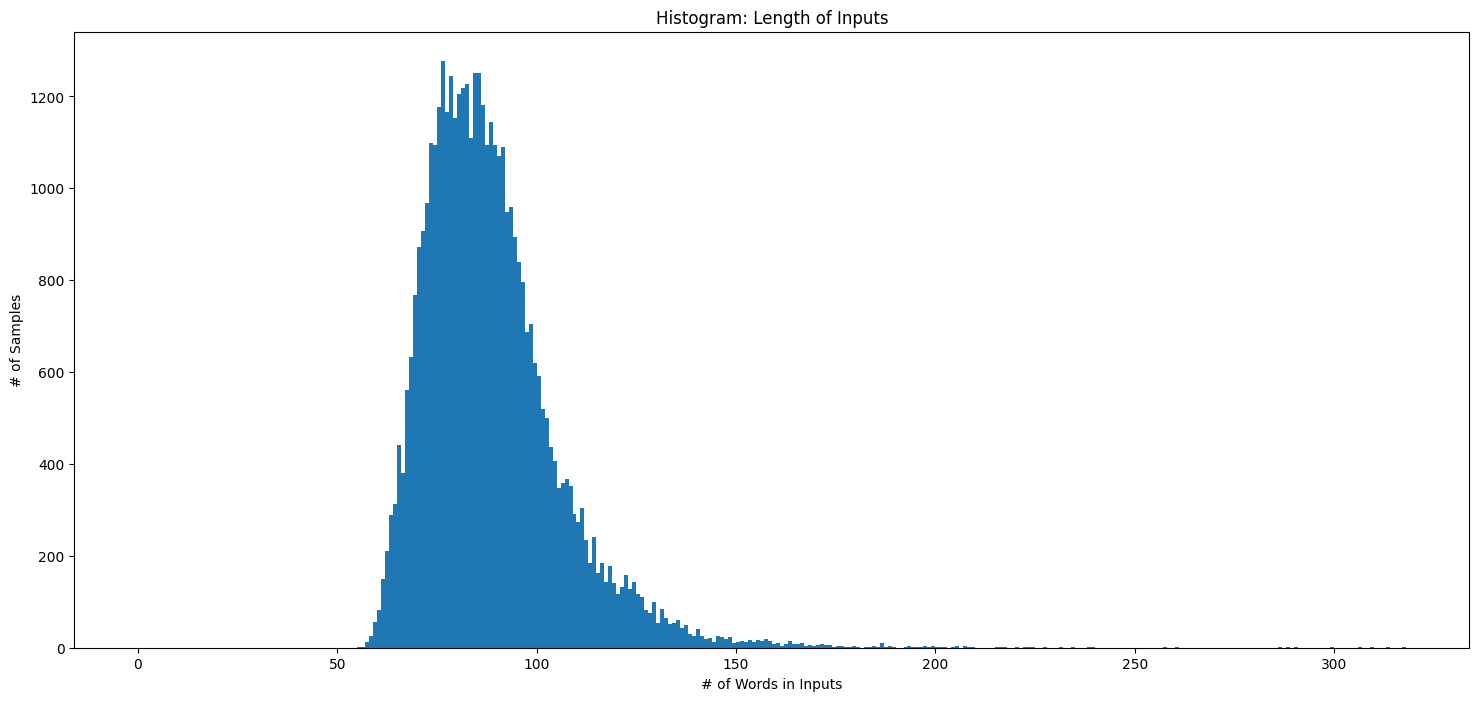

The maximum length of the inputs (in words) is 317 words.


In [3]:
df['input_length'] = df['context'].str.split().str.len()

n_bin= 318
df.hist('input_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of Inputs')
plt.xlabel('# of Words in Inputs')
plt.ylabel('# of Samples')
plt.show()

print(f"The maximum length of the inputs (in words) is {max(df['input_length'])} words.")

#### Trim Overly Lengthy Samples

In [8]:
df = df[df['input_length'] < 151]

df = df.drop(columns=['input_length']).reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   context  43400 non-null  object
 1   labels   43400 non-null  int64 
 2   0        43400 non-null  object
 3   1        43400 non-null  object
 4   2        43400 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


#### Convert from DataFrame to Dataset & Split into Training/Testing/Evaluation Datasets

In [9]:
dataset = Dataset.from_pandas(df)

train_testeval = dataset.train_test_split(test_size=0.20)
test_eval = train_testeval['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testeval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)

print(ds['train'].features)

Training Dataset Shape: (34720, 5)
Testing Dataset Shape: (4340, 5)
Evaluation Dataset Shape: (4340, 5)
{'context': Value(dtype='string', id=None), 'labels': Value(dtype='int64', id=None), '0': Value(dtype='string', id=None), '1': Value(dtype='string', id=None), '2': Value(dtype='string', id=None)}


#### Display Example

In [10]:
ds['train'][12]

{'context': 'Based only on the information contained in a brief quote from Wikipedia, answer whether the related claim is True, False or Neither. Use Neither when the Wikipedia quote does not provide the necessary information to resolve the question.\n\n\nPassage: Indiana Pacers: The Pacers were first established in 1967 as a member of the American Basketball Association -LRB- ABA -RRB- and became a member of the NBA in 1976 as a result of the ABA -- NBA merger .\nClaim: The Indiana Pacers were established .\nTrue, False, or Neither?',
 'labels': 0,
 '0': 'True',
 '1': 'False',
 '2': 'Neither'}

#### Create Function to Display an Example Sample

In [11]:
def show_one_example(sample):
    print(f"Context: {sample['context']}")
    print(f"\nGround Truth: {mc_target_values[sample['labels']]}")

#### Display an Example Sample

In [12]:
show_one_example(ds['train'][12])

Context: Based only on the information contained in a brief quote from Wikipedia, answer whether the related claim is True, False or Neither. Use Neither when the Wikipedia quote does not provide the necessary information to resolve the question.


Passage: Indiana Pacers: The Pacers were first established in 1967 as a member of the American Basketball Association -LRB- ABA -RRB- and became a member of the NBA in 1976 as a result of the ABA -- NBA merger .
Claim: The Indiana Pacers were established .
True, False, or Neither?

Ground Truth: True


#### Basic Values/Constants

In [13]:
MODEL_CKPT = "bert-base-uncased"
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-Vitamin_C_Fact_Verification"

STRATEGY = "epoch"
LEARNING_RATE = 5e-5

BATCH_SIZE = 16
NUM_OF_EPOCHS = 2

WEIGHT_DECAY = 0.01
REPORTS_TO = "tensorboard"

set_seed = 42

#### Instantiate Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT,
                                          use_fast=True)

#### Create Preprocessing Function

In [17]:
ending_names = ["0", "1", "2"]

def preprocess_function(samples):
    input_headers = samples["context"]
    input = [[f"{header} {samples[end][i]}" for end in ending_names]
             for i, header in enumerate(input_headers)]

    input = sum(input, [])

    tokenized_samples = tokenizer(input, truncation=True)

    return {k: [v[i:i + len(ending_names)] for i in range(0,
                                                          len(v),
                                                          len(ending_names))]
            for k, v in tokenized_samples.items()}

#### Apply Preprocessing Function to Dataset

In [18]:
encoded_ds = ds.map(preprocess_function,
                    batched=True)

Map:   0%|          | 0/34720 [00:00<?, ? examples/s]

Map:   0%|          | 0/4340 [00:00<?, ? examples/s]

Map:   0%|          | 0/4340 [00:00<?, ? examples/s]

In [19]:
encoded_ds['train'].features

{'context': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None),
 '0': Value(dtype='string', id=None),
 '1': Value(dtype='string', id=None),
 '2': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None)}

#### Instantiate Model

In [20]:
model = AutoModelForMultipleChoice.from_pretrained(MODEL_CKPT)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define TrainingArguments

In [21]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=WEIGHT_DECAY,
    report_to=REPORTS_TO,
    logging_first_step=True,
    hub_private_repo=True,
    group_by_length=True,
    push_to_hub=True
)

#### Define Data Collator Class

In [22]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad inputs
    for the multiple choices received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()}
                               for i in range(num_choices)]
                              for feature in features]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Unflatten
        batch = {k: v.view(batch_size,
                           num_choices,
                           -1)
                 for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels,
                                       dtype=torch.int64)
        return batch

#### Create Function to Compute Metrics

In [23]:
def compute_metrics(predictions):
    preds, labels = predictions
    preds = np.argmax(preds, axis=1)
    return {"accuracy": (preds == labels).astype(np.float32).mean().item()}

#### Instantiate Trainer

In [24]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["eval"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer),
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Vitamin_C_Fact_Verification into local empty directory.


#### Train Model

In [25]:
train_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698500,0.689356,0.686406
2,0.555500,0.632921,0.723963


#### Push to HuggingFace Hub

In [26]:
trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug01_18-18-45_88d15003d599/events.out.tfevents.1690913970.88d15003d599.608.0:   0%|         …

To https://huggingface.co/DunnBC22/bert-base-uncased-Vitamin_C_Fact_Verification
   4e37efd..63dde3a  main -> main

   4e37efd..63dde3a  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Vitamin_C_Fact_Verification
   63dde3a..5333b3f  main -> main

   63dde3a..5333b3f  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Vitamin_C_Fact_Verification/commit/63dde3a41dad5f77d280e52d41987b54d6a7a3d9'

#### Save Model & Metrics

In [28]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

To https://huggingface.co/DunnBC22/bert-base-uncased-Vitamin_C_Fact_Verification
   5333b3f..9253a0e  main -> main

   5333b3f..9253a0e  main -> main



***** train metrics *****
  epoch                    =        2.0
  total_flos               = 15225885GF
  train_loss               =     0.6937
  train_runtime            = 1:38:39.06
  train_samples_per_second =     11.732
  train_steps_per_second   =      0.733


### Notes & Other Takeaways From This Project
****
- I am glad to see that the metric results for this project are better than the results of past Multiple Choice models that I have trained. I think I found what was causing the issue.

****

#### Citation

- Model Checkpoint

    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805%7D, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib%7D, bibsource = {dblp computer science bibliography, https://dblp.org%7D}

- Dataset

    > @article{srivastava2022beyond, title={Beyond the imitation game: Quantifying and extrapolating the capabilities of language models}, author={Srivastava, Aarohi and Rastogi, Abhinav and Rao, Abhishek and Shoeb, Abu Awal Md and Abid, Abubakar and Fisch, Adam and Brown, Adam R and Santoro, Adam and Gupta, Aditya and Garriga-Alonso, Adri{\`a} and others}, journal={arXiv preprint arXiv:2206.04615}, year={2022}}